# Overview (please read this first!)

In this tutorial, you will learn to:

1. use different vector representation of text documents (BOW, LSA)
2. calculate similarities of documents based on these vector representations.
3. automatically find near-duplicates in a large corpus of documents.

We will accomplish the above tasks using the `gensim` library. 

So you might need to **download this library** using the command `pip install gensim` from the command line.

The data we will work with (contained in file `news_df.pickle`) consists of a set of nearly 700 recent news articles from various Tunisian websites.


**What you need to do**: execute the cells below in order and answer questions.

In [3]:
!pip install gensim


You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install langdetect

     |████████████████████████████████| 1.0MB 561kB/s eta 0:00:01
  Stored in directory: /home/ubuntu/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
import langdetect

In [9]:
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer

In [10]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import FrenchStemmer

In [11]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models import LsiModel, LdaModel, CoherenceModel
from gensim.models.word2vec import Word2Vec
from gensim import similarities

In [12]:
import pickle
with open('./news_df.pickle', 'rb') as f:
    news_df = pickle.load(f)
news_df.reset_index(inplace=True)
news_df.shape

(704, 5)

In [14]:
news_df.head()

,date,website,headline,short description,hyperlink
0,2020-01-01,webdo.tn,"Réveillon : Saied, Chahed et Fourati à l’avenu...",CP : Présidence du gouvernement\r\n\r\nDans l...,http://www.webdo.tn/2019/12/31/reveillon-saied...
1,2020-01-01,webdo.tn,Kais Saied : » Que 2020 soit l’année de concré...,Kais Saied\r\n\r\nDans une vidéo diffusée par...,http://www.webdo.tn/2019/12/31/kais-saied-que-...
2,2020-01-01,webdo.tn,BCT: Un suspect placé en garde à vue dans une...,Banque centrale de Tunisie\r\n\r\nLa Banque C...,http://www.webdo.tn/2019/12/31/bct-un-suspect-...
3,2020-01-01,webdo.tn,Réveillon : 97 tonnes de produits alimentaires...,\r\n\r\nLes équipes de contrôle sanitaire rele...,http://www.webdo.tn/2019/12/31/reveillon-97-to...
4,2020-01-01,webdo.tn,"Finalement, les Tunisiens n’auront pas un gouv...",Habib Jemli\r\n\r\nNon l'annonce de la compos...,http://www.webdo.tn/2019/12/31/finalement-les-...


In [15]:
news_df.groupby('website').aggregate('count')

,date,headline,short description,hyperlink
website,,,,
businessnews,129,129,129,129
kapitalis.com,47,47,47,47
mosaiquefm.net,78,78,78,78
tuniscope.com,48,48,48,48
tunisienumerique.com,207,207,207,207
webdo.tn,100,100,100,100
webmanagercenter.com,95,95,95,95


In [16]:
news_df.shape

(704, 5)

In [17]:
news_df['headln+descr'] = news_df.apply(lambda row: (row['headline']+"\n"+row['short description']), axis=1)
news_df.head()

,date,website,headline,short description,hyperlink,headln+descr
0,2020-01-01,webdo.tn,"Réveillon : Saied, Chahed et Fourati à l’avenu...",CP : Présidence du gouvernement\r\n\r\nDans l...,http://www.webdo.tn/2019/12/31/reveillon-saied...,"Réveillon : Saied, Chahed et Fourati à l’avenu..."
1,2020-01-01,webdo.tn,Kais Saied : » Que 2020 soit l’année de concré...,Kais Saied\r\n\r\nDans une vidéo diffusée par...,http://www.webdo.tn/2019/12/31/kais-saied-que-...,Kais Saied : » Que 2020 soit l’année de concré...
2,2020-01-01,webdo.tn,BCT: Un suspect placé en garde à vue dans une...,Banque centrale de Tunisie\r\n\r\nLa Banque C...,http://www.webdo.tn/2019/12/31/bct-un-suspect-...,BCT: Un suspect placé en garde à vue dans une...
3,2020-01-01,webdo.tn,Réveillon : 97 tonnes de produits alimentaires...,\r\n\r\nLes équipes de contrôle sanitaire rele...,http://www.webdo.tn/2019/12/31/reveillon-97-to...,Réveillon : 97 tonnes de produits alimentaires...
4,2020-01-01,webdo.tn,"Finalement, les Tunisiens n’auront pas un gouv...",Habib Jemli\r\n\r\nNon l'annonce de la compos...,http://www.webdo.tn/2019/12/31/finalement-les-...,"Finalement, les Tunisiens n’auront pas un gouv..."


*****

## Data preprocessing

A typical text preprocessing pipeline:

    I. Pre-tokenization document processing
      filter out documents by language using a language detector
      orthographic normalization for e.g. e_accent --? e ; l' ==> le or la
      lowercasing
      remove noise/unwanted characters; this is usually accomplished in the tokenization process.

    II. Tokenization

    III. Post-tokenization document processing
       remove words containing non-French characters
       remove stopwords and one-letter words
       stemming
       word ngrams instead of 1grams
       remove documents that are too short

I have already implemented this pipeline (partially) in the function `preprocess_text` below.

In [18]:
### Make sure there are no duplicate titles

u = news_df.headline.drop_duplicates(inplace=False, keep='last')
assert u.shape[0] == news_df.shape[0]

In [26]:
## Define the preprocessing pipeline in a function

tokenize_regex = "(\w+)|(\w+(-\w+)+)"
tokenize_regex = "\w+|\w+-\w+"

french_stemmer1 = SnowballStemmer('french')
french_stemmer2 = FrenchStemmer()
stop_words_fr = stopwords.words('french')

MIN_CLEAN_TOKENS = 3

def preprocess_text(doc):
    ## pre-tokenization document processing
    #  language detection
    if langdetect.detect(doc)!='fr': return []

    #  lowercasing
    doc = doc.lower()

    #  remove noise/unwanted characters; this is already accomplished by tokenization process.

    ## tokenization
    tokens = regexp_tokenize(doc,tokenize_regex)

    ## post-tokenization document processing

    #   remove stopwords and one-letter words
    tokens = [tok for tok in tokens if (tok not in stop_words_fr and len(tok)>1)]

    #   stemming
    tokens = [french_stemmer1.stem(tok) if len(tok)>=7 else tok for tok in tokens]

    #   word ngrams instead of 1grams

    #   remove documents that are too short  (return [])
    if len(doc) < MIN_CLEAN_TOKENS:
        return []

    return tokens

# FOR DEBUGGING
print("Unit test of preprocess_text function on one document:\n")
doc=news_df['headln+descr'][0]
print("-----raw document:")
print(doc)
print()
print("-----preprocessed document:")
print(preprocess_text(doc))

Unit test of preprocess_text function on one document:

-----raw document:
Réveillon : Saied, Chahed et Fourati à l’avenue Habib Bourguiba
 CP : Présidence du gouvernement

Dans le cadre du suivi de la situation sécuritaire à l'occasion de la fête de fin d'année, le président...

-----preprocessed document:
['réveillon', 'saied', 'chahed', 'fourat', 'avenue', 'habib', 'bourguib', 'cp', 'président', 'gouvern', 'cadre', 'suivi', 'situat', 'sécuritair', 'occas', 'fête', 'fin', 'année', 'président']


In [27]:
## Preprocess all documents and store the result in a new column of the data frame

news_df['preproc_headln+descr'] = news_df['headln+descr'].map(preprocess_text)
news_df.head()

,date,website,headline,short description,hyperlink,headln+descr,preproc_headln+descr
0,2020-01-01,webdo.tn,"Réveillon : Saied, Chahed et Fourati à l’avenu...",CP : Présidence du gouvernement\r\n\r\nDans l...,http://www.webdo.tn/2019/12/31/reveillon-saied...,"Réveillon : Saied, Chahed et Fourati à l’avenu...","[réveillon, saied, chahed, fourat, avenue, hab..."
1,2020-01-01,webdo.tn,Kais Saied : » Que 2020 soit l’année de concré...,Kais Saied\r\n\r\nDans une vidéo diffusée par...,http://www.webdo.tn/2019/12/31/kais-saied-que-...,Kais Saied : » Que 2020 soit l’année de concré...,"[kais, saied, 2020, année, concrétis, revend, ..."
2,2020-01-01,webdo.tn,BCT: Un suspect placé en garde à vue dans une...,Banque centrale de Tunisie\r\n\r\nLa Banque C...,http://www.webdo.tn/2019/12/31/bct-un-suspect-...,BCT: Un suspect placé en garde à vue dans une...,"[bct, suspect, placé, garde, vue, affair, déto..."
3,2020-01-01,webdo.tn,Réveillon : 97 tonnes de produits alimentaires...,\r\n\r\nLes équipes de contrôle sanitaire rele...,http://www.webdo.tn/2019/12/31/reveillon-97-to...,Réveillon : 97 tonnes de produits alimentaires...,"[réveillon, 97, tonnes, produit, alimentair, i..."
4,2020-01-01,webdo.tn,"Finalement, les Tunisiens n’auront pas un gouv...",Habib Jemli\r\n\r\nNon l'annonce de la compos...,http://www.webdo.tn/2019/12/31/finalement-les-...,"Finalement, les Tunisiens n’auront pas un gouv...","[final, tunisien, gouvern, avant, 2020, habib,..."


**Questions**

1. The `preprocess_text` function takes a raw text document (i.e. a string of characters) as input. What does it return?
2. Create a new column in `news_df` called *nb_words* that contains the number of words in the preprocessed document.
3. Plot the distribution of *nb_words* as a histogram.
4. Find and display all rows in `news_df` where the preprocessed document is an empty list (i.e. where nb_words is zero).

In [ ]:
## Write your answers below


#Q1.
detect the frensh words,remove stop words,translate all words to lowercase,tokenize,remove words that there length is less than 3 and if the word's length is more than 7 then apply stemming

In [31]:
#q2.
l=[len(i) for i in news_df['preproc_headln+descr'] ]
news_df['nb_words']=l

In [34]:
news_df.head()

,date,website,headline,short description,hyperlink,headln+descr,preproc_headln+descr,nb_words
0,2020-01-01,webdo.tn,"Réveillon : Saied, Chahed et Fourati à l’avenu...",CP : Présidence du gouvernement\r\n\r\nDans l...,http://www.webdo.tn/2019/12/31/reveillon-saied...,"Réveillon : Saied, Chahed et Fourati à l’avenu...","[réveillon, saied, chahed, fourat, avenue, hab...",19
1,2020-01-01,webdo.tn,Kais Saied : » Que 2020 soit l’année de concré...,Kais Saied\r\n\r\nDans une vidéo diffusée par...,http://www.webdo.tn/2019/12/31/kais-saied-que-...,Kais Saied : » Que 2020 soit l’année de concré...,"[kais, saied, 2020, année, concrétis, revend, ...",20
2,2020-01-01,webdo.tn,BCT: Un suspect placé en garde à vue dans une...,Banque centrale de Tunisie\r\n\r\nLa Banque C...,http://www.webdo.tn/2019/12/31/bct-un-suspect-...,BCT: Un suspect placé en garde à vue dans une...,"[bct, suspect, placé, garde, vue, affair, déto...",26
3,2020-01-01,webdo.tn,Réveillon : 97 tonnes de produits alimentaires...,\r\n\r\nLes équipes de contrôle sanitaire rele...,http://www.webdo.tn/2019/12/31/reveillon-97-to...,Réveillon : 97 tonnes de produits alimentaires...,"[réveillon, 97, tonnes, produit, alimentair, i...",23
4,2020-01-01,webdo.tn,"Finalement, les Tunisiens n’auront pas un gouv...",Habib Jemli\r\n\r\nNon l'annonce de la compos...,http://www.webdo.tn/2019/12/31/finalement-les-...,"Finalement, les Tunisiens n’auront pas un gouv...","[final, tunisien, gouvern, avant, 2020, habib,...",19


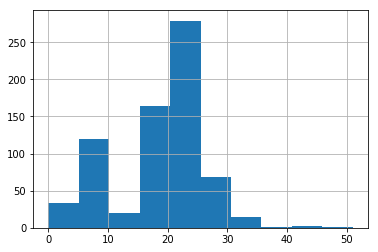

In [33]:
#q3.
news_df['nb_words'].hist()

*****

In [37]:
#Q4.
for j in range(0,news_df['nb_words'].shape[0]):
    if news_df.loc[j,'nb_words']==0 :
        print("la ligne supprimée",j,news_df.loc[j,'nb_words'])
        news_df=news_df.drop([j],axis=0)
        
    
        

la ligne supprimée 56 0
la ligne supprimée 292 0
la ligne supprimée 293 0
la ligne supprimée 424 0
la ligne supprimée 430 0
la ligne supprimée 518 0
la ligne supprimée 560 0
la ligne supprimée 565 0
la ligne supprimée 567 0
la ligne supprimée 678 0
la ligne supprimée 681 0
la ligne supprimée 692 0
la ligne supprimée 696 0


In [38]:
news_df.shape

(691, 8)

## Vector representation of corpus

### Create dictionary (vocabulary) of corpus

In [39]:
news_df.shape

(691, 8)

In [40]:
# FIRST LET'S REMOVE ALL ROWS WHERE THE PREPROCESSED DOCUMENT IS EMPTY

idx = news_df['preproc_headln+descr'].map(lambda doc: doc==[])
print("Number of dropped rows:", idx.sum())
news_df.drop(labels=news_df.index[idx], axis=0,inplace=True)
news_df.shape

Number of dropped rows: 0


(691, 8)

In [41]:
# Create dictionary using corpus

dictionary = Dictionary(news_df['preproc_headln+descr'].tolist())
len(dictionary)

2681

In [42]:
# Remove rare words (that have very low document frequency)

from six import iteritems
MIN_TOKEN_DOC_FREQ = 5

idx = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq < MIN_TOKEN_DOC_FREQ]
print("Number of rare words:", len(idx))
dictionary.filter_tokens(idx) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
len(dictionary)

Number of rare words: 2197


484

In [43]:
vocab_list = list(dictionary.token2id.keys())

In [72]:
vocab_list[5]

'gouvern'

In [44]:
print(vocab_list[0:100])

['année', 'cadre', 'chahed', 'cp', 'fin', 'gouvern', 'habib', 'président', 'saied', 'situat', 'sécuritair', '2020', '31', 'kais', 'kaïs', 'mardi', 'peuple', 'présent', 'républ', 'saïed', 'vidéo', '2019', 'affair', 'audit', 'bct', 'central', 'cour', 'décembr', 'dévoil', 'garde', 'indiqu', 'suspect', 'tunis', '30', 'effectu', 'minister', 'plus', 'santé', 'annonc', 'avant', 'chargé', 'comme', 'commun', 'composit', 'final', 'jemli', 'lieu', 'non', 'nouveau', 'tunisien', 'annuel', 'devis', 'financi', 'gouverneur', 'périod', 'révèle', 'révélé', 'don', 'enfanc', 'famill', 'femme', 'accord', 'contre', 'corrupt', 'déclar', 'déput', 'fm', 'inlucc', 'instanc', 'lutte', 'national', 'radio', 'shems', 'soupçon', 'avoir', 'communiqu', 'critiqu', 'devant', 'droits', 'décis', 'mois', 'présidentiel', 'surpris', 'urgenc', 'état', 'décidé', 'intérieur', 'nouvel', 'sécur', 'toute', 'augment', 'cette', 'cours', 'dinars', 'el', 'mille', 'municipal', 'après', 'gouvernorat', 'hier']


**Questions**

1. How many distint words does this corpus contain before and after removing *rare* words?
2. Give/display all *rare* words that were removed from the dictionary.

In [ ]:
## Write your answers below


#q1.
2681 words before removing and after removing 484 words


In [60]:
#Q2.
dictionary_ = Dictionary(news_df['preproc_headln+descr'].tolist())
for i in dictionary_.keys():
    if i in idx:
        print (dictionary_[i])

avenue
bourguib
fourat
fête
occas
réveillon
suivi
concrétis
diffus
revend
banque
détourn
intern
md
mission
ordon
placé
vue
10870
97
alimentair
consomm
contrôl
détruit
impropr
inspect
jusqu
produit
relev
sanitair
tonnes
visit
équip
avoirs
erreur
manque
ordre
attribu
centr
chine
chinois
petite
profit
chawki
dizain
enquêt
tabib
exprim
libert
observatoir
prolong
rappel
an
forces
mainten
niveau
parer
sécuris
vigil
élevé
éventual
100
500
dépass
fiscal
kef
mani
recet
signif
agriculteur
bouzid
désol
jetées
lait
olives
photo
pêches
réseau
scènes
sidi
détérior
dû
faim
protestatair
sauvag
tatatouin
transfer
discour
désorm
prononc
accoutum
accueil
mosaïqu
nés
rendez
inopin
oper
product
rades
salle
tourn
électr
rendus
visitent
bonne
vœux
passager
prévoir
puis
résiduel
sud
remis
14h15mn
600
72
atr
atterr
avion
aéroport
compagn
deuxiem
express
karkouan
terminal
tunisair
24h
34
arous
boumhel
fouchan
hammam
khelidi
lif
mhamdi
mm
mornag
mégrin
pluie
quantit
radès
voici
allumet
régie
tabacs
attach
fond
a

### Vector representation#1: count-based BOW

In [70]:
?dictionary.doc2bow

In [62]:
corpus_tokenized = news_df['preproc_headln+descr'].tolist()
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_tokenized]

In [63]:
type(corpus_bow),len(corpus_bow)

(list, 691)

In [64]:
len(corpus_bow) == news_df.shape[0]

True

In [65]:
type(corpus_bow[0]), len(corpus_bow[0])

(list, 11)

In [66]:
# representation of the first document
corpus_bow[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1)]

In [67]:
# the first document as a list of words
corpus_tokenized[0]

['réveillon',
 'saied',
 'chahed',
 'fourat',
 'avenue',
 'habib',
 'bourguib',
 'cp',
 'président',
 'gouvern',
 'cadre',
 'suivi',
 'situat',
 'sécuritair',
 'occas',
 'fête',
 'fin',
 'année',
 'président']

In [73]:
corpus_bow[50]

[(74, 1), (97, 1), (154, 1), (195, 1), (216, 1), (217, 1)]

In [74]:
corpus_tokenized[50]

['peines',
 'substitu',
 'incarcer',
 'effac',
 'antécédent',
 'judiciair',
 'près',
 '22',
 'person',
 'bénéfici',
 'effac',
 'leurs',
 'antécédent',
 'judiciair',
 'après',
 'avoir',
 'accompl',
 'peine',
 'substitu',
 'soulign',
 'agence',
 'tap',
 'moez']

**Questions**

Notice that `corpus_bow` is actually a sparse (efficient) representation of the vector of each document in the corpus. The following questions will help you understand this representation.

1. `corpus_bow` is a list. How many elements does this list contain and what does each element correspond to?
2. The first element of `corpus_bow` is a list of 18 pairs of numbers. What do the numbers in each pair correspond to, i.e. what do they represent?
3. How many zero values does the vector of the **first document** of the corpus contain? Explain your answer.
4. Determine the number of elements of `corpus_bow` that contain less than 3 dictionary words. Hint: this is somewhat related to the previous question...
5. Determine the 10 most frequent words in this corpus. (use a *for* loop to calcuate the total frequency of each word using `corpus_bow` ...)

BONUS QUESTION: Which un-stemmed words do the 10 most frequent words correspond to? You should do this programmatically and not manually.  (you can create a dictionary that contains the list of words corresponding to each stemmed word ...)

In [ ]:
## Write your answers below


#q1.
691 elements in corpus bow representing words

In [75]:
len(corpus_bow)

691

In [77]:
len(corpus_bow[0]),len(corpus_tokenized[0])

(11, 19)

#q2.
each pair correspond to (token_id, token_count) token_id is the index of the token in the dictionnary and token count is the frequency of that token

In [79]:
#q3.
len(dictionary)-len(corpus_bow[0])

473

In [80]:
#q4.
len([1 for x in corpus_bow if len(x)<3 ])

26

In [83]:
[ corpus_tokenized[i] for i,x in enumerate(corpus_bow) if len(x)<3 ]

[['démarrag',
  'instruct',
  'judiciair',
  'affair',
  'appareil',
  'dit',
  'sécuritair'],
 ['emrhod', 'consulting', 'fête', 'vingtiem', 'anniversair'],
 ['taoufik', 'abbes', 'nouveau', 'pdg', 'rnta'],
 ['accident', 'entre', 'bus', 'groupe', 'chimiqu', 'camion'],
 ['datant',
  '2e',
  'guerre',
  'mondial',
  'quatre',
  'obus',
  'désamorc',
  'bizert',
  'découvert',
  'hasard',
  'agriculteur',
  'quatre',
  'obus',
  'datant',
  'second',
  'guerre',
  'mondial',
  'désamorc',
  'unités',
  'armée'],
 ['trembl', 'terre', 'détect', 'remada'],
 ['gouvern', 'jamli', 'réaction', 'tardé'],
 ['lotfi', 'mraïhi', 'révolu', 'lieu', 'lotfi', 'mraïhi', 'révolu', 'lieu'],
 ['arp', 'pourvoi', 'siège', 'vacant', 'boubak', 'zakham'],
 ['date', 'démarrag', 'soldes', 'hiver'],
 ['aptbef', 'banqu', 'essuyé', 'aucune', 'perte', 'suite', 'incident', 'bct'],
 ['hatem', 'mliki', 'object', 'majeur', 'contre', 'gouvern'],
 ['concour',
  'réorient',
  'universitair',
  '2019',
  'calendri',
  'concour'

In [104]:
#q5.
def calcul_freq_indice(ind):
    s=0
    for i in range(0,len(corpus_bow)):
        for j in corpus_bow[i]:
            if j[0]==ind:
                s=s+j[1]
    return (s)
                    

In [128]:
dicti={}
for i in range(len(dictionary)):
    dicti[i]=calcul_freq_indice(i)
    

dict_sorted={k: v for k, v in sorted(dicti.items(), key=lambda item: item[1],reverse=True)}
j=0
for i in dict_sorted.items():
        j=j+1
        if j<=10:
            print(vocab_list[i[0]],i[1])
        else :
            break

gouvern 384
tunis 337
jemli 252
président 199
habib 191
janvi 162
2020 144
ministr 130
ennahdh 121
républ 92


****

### Vector representation#2: BOW with tfidf weighting

In [129]:
# Create a new TfidfModel using the corpus
tfidf_model = TfidfModel(corpus_bow)

# Calculate the tfidf weights of doc: tfidf_weights
corpus_bow_tfidf = [tfidf_model[doc] for doc in corpus_bow]

#same thing
#corpus_bow_tfidf = list(tfidf_model[corpus_bow])

In [130]:
type(corpus_bow), type(corpus_bow_tfidf), len(corpus_bow), len(corpus_bow_tfidf)

(list, list, 691, 691)

In [131]:
# representation of the first document
corpus_bow_tfidf[0]

[(0, 0.3230913960467907),
 (1, 0.37611836652236286),
 (2, 0.3077114618631649),
 (3, 0.37611836652236286),
 (4, 0.36618264982381554),
 (5, 0.07864837048878841),
 (6, 0.12554580789627895),
 (7, 0.25001357898842047),
 (8, 0.2469290034903803),
 (9, 0.3230913960467907),
 (10, 0.36618264982381554)]

**Questions**

1. Give the count-based and tfidf-based BOW representations of the **100th document** in the corpus (at index 99).
2. Which word of the **100th document** has the highest tfidf value?  Hint: you will need the `vocab` variable defined above ...
3. Is this word the most frequent word? Explain your answer.
4. Deduce an approximate value of the document frequency of this word based on your previous answers.

In [ ]:
## Write your answers below


In [132]:
#q1.
corpus_bow_tfidf[99]

[(3, 0.2774369630019715),
 (7, 0.09220901481778182),
 (8, 0.18214274787721943),
 (11, 0.10347453176132869),
 (18, 0.13494416444852367),
 (45, 0.08545523763258811),
 (129, 0.0971565541813026),
 (145, 0.5044148004566006),
 (182, 0.189261789884224),
 (186, 0.29533762266575164),
 (194, 0.22361357176133417),
 (330, 0.613364710196132),
 (331, 0.1788670569433979)]

In [142]:
#q2.
print(vocab_list[330],'has the highest tfidf value')

jawhar has the highest tfidf value


#q3.
NO it can be not because it is only the highest tfidf value in the 100th document 

***

### Vector representation#3: Latent Semantic Analysis (LSA)

- LSA is basically a linear transformation (projection) of the high-dimensional BOW representation into a low-dimensional vector space. 

- LSA is equivalent to Principal Components Analysis (PCA)!

- For historical reasons, LSA is sometimes also called Latent Semantic Indexing (LSI).

In [143]:
n_dim = 10

In [158]:
?LsiModel

In [145]:
# initialize LSA transformation
lsi_model = LsiModel(corpus_bow_tfidf, id2word=dictionary, num_topics=n_dim)

# transform corpus
corpus_lsi = list(lsi_model[corpus_bow_tfidf])

type(corpus_bow), type(corpus_lsi), len(corpus_bow), len(corpus_lsi)

(list, list, 691, 691)

In [152]:
corpus_lsi 

[[(0, 0.1697160664613051),
  (1, -0.14967147233179873),
  (2, 0.019391192137739103),
  (3, -0.05379589124783255),
  (4, -0.06601798504025437),
  (5, 0.13177478628989164),
  (6, 0.004826170934169731),
  (7, 0.05412659210810623),
  (8, 0.0939258644579763),
  (9, 0.0984680090582657)],
 [(0, 0.2884313925757978),
  (1, -0.5031316159217039),
  (2, 0.08808822082123234),
  (3, -0.1448652420692922),
  (4, -0.12910702758432424),
  (5, 0.29417483314415777),
  (6, -0.14087239047025538),
  (7, 0.005507808186165717),
  (8, 0.023995490647959937),
  (9, 0.01637699648617978)],
 [(0, 0.09872603078400319),
  (1, -0.06194314607667858),
  (2, 0.06703517335494483),
  (3, 0.0031201276935696335),
  (4, -0.1523702657594045),
  (5, -0.1151679555641919),
  (6, 0.09483574988100917),
  (7, -0.004965173821117793),
  (8, 0.0225201143087481),
  (9, 0.08040117908704929)],
 [(0, 0.08308203470958003),
  (1, -0.04720986159871764),
  (2, 0.112367739485695),
  (3, 0.02710465641819533),
  (4, -0.20840119910772376),
  (5, -0

In [146]:
# each element of corpus_bow is a list of n pairs, where n is the number of dictionary words in the corresponding document
corpus_bow[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1),
 (10, 1)]

In [147]:
# each element of corpus_bow_tfidf is also a list of n pairs, where n is the number of dictionary words in the corresponding document
corpus_bow_tfidf[0]

[(0, 0.3230913960467907),
 (1, 0.37611836652236286),
 (2, 0.3077114618631649),
 (3, 0.37611836652236286),
 (4, 0.36618264982381554),
 (5, 0.07864837048878841),
 (6, 0.12554580789627895),
 (7, 0.25001357898842047),
 (8, 0.2469290034903803),
 (9, 0.3230913960467907),
 (10, 0.36618264982381554)]

In [148]:
# each element of corpus_lsi is a list of 10 pairs (10 is the chosen number of dimensions)
corpus_lsi[0]

[(0, 0.1697160664613051),
 (1, -0.14967147233179873),
 (2, 0.019391192137739103),
 (3, -0.05379589124783255),
 (4, -0.06601798504025437),
 (5, 0.13177478628989164),
 (6, 0.004826170934169731),
 (7, 0.05412659210810623),
 (8, 0.0939258644579763),
 (9, 0.0984680090582657)]

In [149]:
# compare our 3 different representations for the first 20 documents in the corpus
for i in range(20):
    print(len(corpus_bow[i]),len(corpus_bow_tfidf[i]),len(corpus_lsi[i]))

11 11 10
13 13 10
14 14 10
7 7 10
15 15 10
12 12 10
9 9 10
15 15 10
13 13 10
7 7 10
9 9 10
11 11 10
9 9 10
16 16 10
8 8 10
11 11 10
15 15 10
13 13 10
12 12 10
21 21 10


In [150]:
# interpretation of the elements of corpus_lsi
lsi_model.print_topics()

[(0,
  '0.291*"jemli" + 0.279*"gouvern" + 0.245*"habib" + 0.184*"président" + 0.166*"ennahdh" + 0.166*"ministr" + 0.157*"chef" + 0.155*"tunis" + 0.142*"janvi" + 0.136*"annonc"'),
 (1,
  '-0.315*"saïed" + -0.311*"président" + -0.291*"républ" + -0.289*"kaïs" + -0.230*"kais" + -0.218*"saied" + 0.218*"jemli" + 0.206*"habib" + -0.192*"ghannouch" + 0.167*"gouvern"'),
 (2,
  '0.515*"ministr" + 0.266*"biograph" + 0.256*"propos" + 0.224*"poste" + 0.208*"affair" + -0.165*"ennahdh" + -0.164*"confianc" + -0.152*"tounes" + 0.150*"etat" + -0.128*"ghannouch"'),
 (3,
  '-0.235*"habib" + -0.228*"kaïs" + -0.226*"saïed" + -0.218*"jamli" + 0.208*"arp" + 0.201*"ministr" + -0.171*"jemli" + -0.169*"composit" + 0.165*"confianc" + 0.148*"biograph"'),
 (4,
  '0.365*"ghannouch" + 0.287*"rached" + -0.210*"2020" + -0.201*"janvi" + 0.174*"ennahdh" + -0.169*"2019" + 0.159*"propos" + -0.157*"tounes" + 0.153*"ministr" + 0.151*"jamli"'),
 (5,
  '0.430*"kais" + 0.419*"saied" + -0.378*"saïed" + -0.375*"kaïs" + 0.159*"rép

**Questions**

1. Explain the output of the call to the `lsi_model.print_topics` function above.
2. Give the LSA vector of the **20th document** in our corpus.
3. Explain what the numbers in this vector represent or mean.

In [ ]:
## WRITE YOUR ANSWERS BELOW


#q1.
lsi_model.print_topics represent the dimensionnality of documents and the topic of each document

In [157]:
#q2.
corpus_lsi[19]

[(0, 0.12792398234375316),
 (1, -0.03975166160622574),
 (2, 0.06633421133083323),
 (3, -0.020207778873386997),
 (4, -0.1890708240966339),
 (5, -0.11556946788335506),
 (6, 0.13073836513890316),
 (7, 0.04445243467531673),
 (8, 0.11712437055015981),
 (9, 0.1440952287107889)]

#q3.
the numbers represent weights of the words

*****

## Recap of the 3 vector representations

Above we have discussed three different vector representations of our corpus: each one represents a text document as a numeric vector. The vector is either represented implicitly (as a list of pairs) or explicitly (as an array of numbers).

1. simple BOW
2. tfidf BOW
3. LSA


**Questions:**

1. How many dimensions does each representation have? Be careful: this might be tricky.
2. Give the three different representations of the **100th document**.
3. What are the advantages of the LSA representation do you think?

In [153]:
type(corpus_bow),type(corpus_bow_tfidf),type(corpus_lsi)

(list, list, list)

In [154]:
len(corpus_bow),len(corpus_bow_tfidf),len(corpus_lsi)

(691, 691, 691)

In [155]:
# representations of the first document
len(corpus_bow[0]),len(corpus_bow_tfidf[0]),len(corpus_lsi[0])

(11, 11, 10)

In [156]:
# count-based BOW representation of the 100th document
corpus_bow[99]

[(3, 1),
 (7, 1),
 (8, 1),
 (11, 1),
 (18, 1),
 (45, 1),
 (129, 1),
 (145, 2),
 (182, 1),
 (186, 1),
 (194, 1),
 (330, 2),
 (331, 1)]

In [ ]:
## ENTER YOUR ANSWERS BELOW


#q1.
dimension of corpus_lsi =10 dimension corpus_bow_tfidf=484 and dimension corpus_bow=484

In [165]:
#q2.
corpus_bow[99]

[(3, 1),
 (7, 1),
 (8, 1),
 (11, 1),
 (18, 1),
 (45, 1),
 (129, 1),
 (145, 2),
 (182, 1),
 (186, 1),
 (194, 1),
 (330, 2),
 (331, 1)]

In [163]:
corpus_bow_tfidf[99]

[(3, 0.2774369630019715),
 (7, 0.09220901481778182),
 (8, 0.18214274787721943),
 (11, 0.10347453176132869),
 (18, 0.13494416444852367),
 (45, 0.08545523763258811),
 (129, 0.0971565541813026),
 (145, 0.5044148004566006),
 (182, 0.189261789884224),
 (186, 0.29533762266575164),
 (194, 0.22361357176133417),
 (330, 0.613364710196132),
 (331, 0.1788670569433979)]

In [164]:
corpus_lsi[99]

[(0, 0.17111879001412278),
 (1, -0.11047969742757643),
 (2, 0.013677202706273314),
 (3, 0.0320020840350873),
 (4, -0.10389323248684001),
 (5, 0.12561722316746993),
 (6, -0.014946059431770877),
 (7, 0.04079529653039609),
 (8, 0.01458692467648312),
 (9, -0.022477635495541003)]

#q3.The advantage of the LSA is that gives you the topics of the content and can reduce the dimension of document

***

## Calculate document similarities based on their vector representations

**Introduction**

Once we have a vector representation of documents, we can now easily calculate the similarity (or distance) between any pair of documents based on their vectors. Similarities are useful in many practical tasks such as:

- information retrieval (search)
- recommender systems
- clustering documents
- finding near-duplicate documents (for example for a plagiarism detection application)

Document similarity is usually calculated as the **cosine** between the two corresponding vectors, as shown in the formula below.

### Calculate cosine similarity directly using mathematical formula

Apply the mathematical formula of cosine similarity directly on document vectors. Assuming u and v are two vectors

    cos(u,v) = dot(u,v) / sqrt( dot(u,u)*dot(v,v) )

where dot() is the dot product.

**Questions**

1. Write a function called `tfidf_cos` described in the comment below.
2. Write a function called `lsi_cos` described in the comment below.
3. Calculate the similarity of the **3rd and 6th documents** using `tfidf_cos`. (at index [2,5] of the matrix)
4. Repeat the previous question using `lsi_cos`.
5. Based on the results of the previous questions and the contents of these two documents, which representation is better, tfidf or LSA? Explain your answer.

In [166]:
'''
Inputs:
 u is a list of tuples containing the tfidf representation of a document
 v is a list of tuples containing the tfidf representation of a document
   Remark: u and v are sparse representations of vectors, hence they do not necessarily have the same length!

Outputs:
 d is the cosine similarity of the two input documents represented by u and v
'''
import math
import numpy
def tfidf_cos(u,v):
    d=numpy.dot(u,v)/ math.sqrt( numpy.dot(u,u)*numpy.dot(v,v) )
    return d

In [168]:
'''
Inputs:
 u is a list of tuples containing the LSI representation of a document
 v is a list of tuples containing the LSI representation of a document
   Remark: u and v are always of the same length!

Outputs:
 d is the cosine similarity of the two input documents represented by u and v
'''

def lsi_cos(u,v):
    d=numpy.dot(u,v)/ math.sqrt( numpy.dot(u,u)*numpy.dot(v,v) )
    return d

In [169]:
# quick test: call the function on the first two documents only

vec1 = [x[1] for x in corpus_lsi[0]]
vec2 = [x[1] for x in corpus_lsi[1]]

tfidf_cos(vec1,vec2)

0.8443670758450097

In [170]:
## The contents of the 3rd and 6th documents

print(news_df['headln+descr'][2])
print('----')
print(news_df['headln+descr'][5])

BCT:  Un suspect placé en garde à vue dans une affaire de détournement de 1,2 MD
 Banque centrale de Tunisie

La Banque Centrale de Tunisie a indiqué, mardi 31 décembre, qu’une mission d’audit interne ordonnée, courant décembre 2019, a dévoilé...
----
Détournement ou erreur ? L’audit de la BCT révèle un manque dans les avoirs en devises


L'audit financier périodique effectué annuellement par la Banque centrale de Tunisie sur ordre du gouverneur de la BCT a révélé un manque dans le...


In [175]:
u=[x[1] for x in corpus_bow_tfidf[2]]
v=[x[1] for x in corpus_bow_tfidf[5]]
tfidf_cos(u,v)

ValueError: shapes (14,) and (12,) not aligned: 14 (dim 0) != 12 (dim 0)

In [174]:
u=[x[1] for x in corpus_lsi[2]]
v=[x[1] for x in corpus_lsi[5]]
lsi_cos(u,v)

0.9680867948401976

### Calculate similarity using `gensim` library

The `similarities.MatrixSimilarity` function in the `gensim` library calculates the **cosine** similarity of any given vector representation of a corpus.

In [176]:
def gensim_cosine_sim_wrapper(corpus_vectors):
    # calculate index for the corpus
    # an index is basically a word2doc mapping and it facilitates similarity calculations   (???)
    corpus_index = similarities.MatrixSimilarity(corpus_vectors)

    corpus_sim = corpus_index[corpus_vectors]

    print("min and max values of similarity matrix:",corpus_sim[corpus_sim<1.0].min(),corpus_sim[corpus_sim<1.0].max())

    plt.figure(figsize=(10,8))
    plt.title('Similarity Matrix of 20 first articles', y=1.05, size=12)
    sns.heatmap(corpus_sim[0:20,0:20], linewidths=0.1, vmax=1.0, square=True, linecolor='white', annot=False, cmap=plt.cm.RdBu)

    return corpus_index, corpus_sim

#### Calculate similarities with simple BOW vectors


/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


min and max values of similarity matrix: 0.0 0.99999994


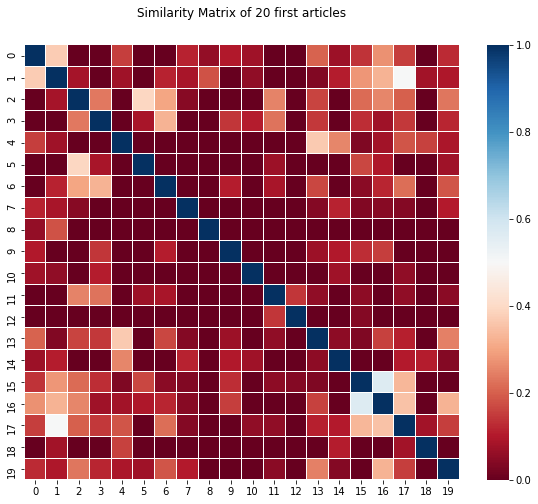

In [177]:
corpus_index1, corpus_sim1 = gensim_cosine_sim_wrapper(corpus_bow)

In [178]:
type(corpus_sim1), corpus_sim1.shape

(numpy.ndarray, (691, 691))

#### Calculate similarities with tfidf vectors


min and max values of similarity matrix: 0.0 0.99999994


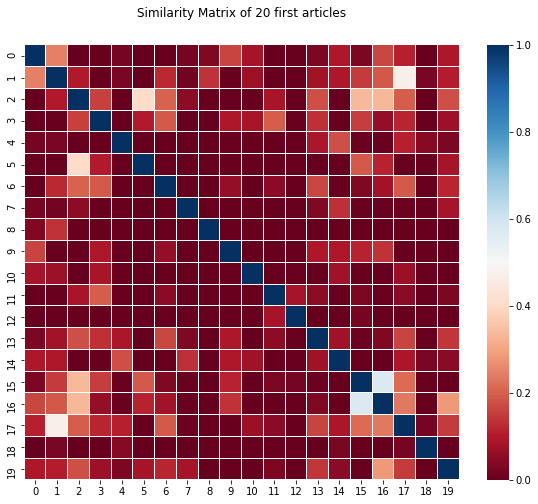

In [179]:
corpus_index2, corpus_sim2 = gensim_cosine_sim_wrapper(corpus_bow_tfidf)

In [180]:
type(corpus_sim2), corpus_sim2.shape

(numpy.ndarray, (691, 691))

#### Calculate similarities with LSA vectors


min and max values of similarity matrix: -0.60093266 0.99999994


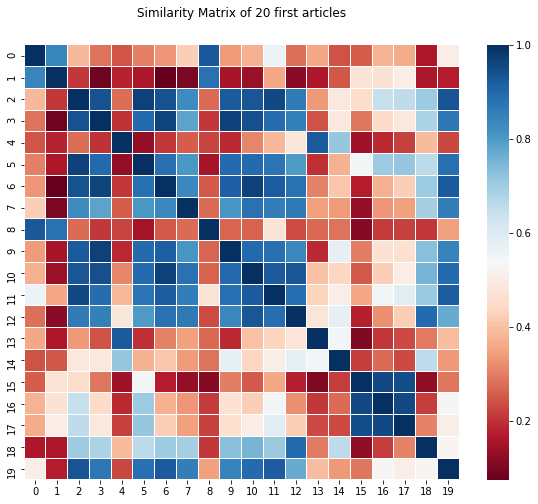

In [181]:
corpus_index3, corpus_sim3 = gensim_cosine_sim_wrapper(corpus_lsi)

In [182]:
type(corpus_sim3), corpus_sim3.shape

(numpy.ndarray, (691, 691))

**Questions:**

1. Take a good look at the three figures above; what can you say about the difference between the three matrices `corpus_sim1`, `corpus_sim2`, and `corpus_sim3`?
2. Determine the value of the similarity between the third and sixth documents for each representation based on these matrices.

In [ ]:
## Write your answers below


#q1.
corpus_sim1 is for similarity in between corpus_bow matrix elements ,corpus_sim2 is for corpus_bow_tfidf similarity and corpus_sim3 is for corpus_lsi similarity.
We notice that corpus_sim3 is the best one because it is more specific and have more blue color that represent a high value of similarity.

In [187]:
#q2.
corpus_sim1[3][6]

0.32732683

In [185]:
corpus_sim2[3][6]

0.1952718

*****

In [186]:
corpus_sim3[3][6]

0.9646843

## Application: finding near-duplicates in a corpus

We already know there are no identical articles in our corpus. But there might be articles that are very similar, for example they different by only a few characters or words. We want to find such articles.

Let's see if we can achieve this using the similarities of their LSA vectors.

**Questions:**

Answer the following questions using the `corpus_sim3` similarity matrix calculated above:

1. Determine the indices of the 10 most similar pairs of articles.
2. Display the rows corresponding to those articles in the `news_df` data frame.
3. After visual inspection of these articles, which pairs are **truly** very similar?
4. Based on the previous answer, do you think LSA is a good method for finding near-duplicate documents?

In [216]:
## Write your answers below
corpus_sim3.shape,news_df.shape

((691, 691), (691, 8))

In [ ]:
#q1.
top_N = 701 #691+10
l=[]
idx = numpy.argpartition(corpus_sim3, corpus_sim3.size - top_N, axis=None)[-top_N:]
result = numpy.column_stack(numpy.unravel_index(idx, corpus_sim3.shape))        

In [228]:
x = result[:,0].ravel().tolist()
y = result[:,1].ravel().tolist()
set(x)==set(y)

True

In [233]:
result

array([[215, 127],
       [127, 215],
       [136, 207],
       ...,
       [  2,   2],
       [  1,   1],
       [690, 690]])

In [230]:
len(x),len(set(x))

(701, 687)

In [218]:
[x for lis in result for x,y in lis]

TypeError: 'numpy.int64' object is not iterable

In [214]:
for i in result.tolist():
    if i[0]!=i[1]:
        l.append((i[0],i[1]))
        print(vocab_list[i[0]],vocab_list[i[1]])

samedi durant
durant samedi
temps tuniso
tuniso temps
tuniso nord
bct fronti
fronti bct
nord tuniso


IndexError: list index out of range

In [215]:
#q2.
l


[(215, 127),
 (127, 215),
 (136, 207),
 (207, 136),
 (207, 209),
 (24, 201),
 (201, 24),
 (209, 207),
 (624, 657)]

In [235]:
[y for x,y in l]

[127, 215, 207, 136, 209, 201, 24, 207, 657]

In [238]:
idx=[x for x,y in l]

In [240]:
news_df.iloc[idx,:]

,date,website,headline,short description,hyperlink,headln+descr,preproc_headln+descr,nb_words
216,2020-01-03,businessnews,"Gouvernement Jamli, les réactions n'ont pas ta...",,gouvernement-jamli-les-reactions-nont-pas-tard...,"Gouvernement Jamli, les réactions n'ont pas ta...","[gouvern, jamli, réaction, tardé]",4
128,2020-01-02,businessnews,"Gouvernement Jamli, les réactions ne se font p...",,gouvernement-jamli-les-reactions-ne-se-font-pa...,"Gouvernement Jamli, les réactions ne se font p...","[gouvern, jamli, réaction, font, attendr]",5
137,2020-01-02,businessnews,"Biographie de Abdelmajid Ben Amara, secrétaire...",,biographie-de-abdelmajid-ben-amara-secretaire-...,"Biographie de Abdelmajid Ben Amara, secrétaire...","[biograph, abdelmajid, ben, amara, secrétair, ...",11
208,2020-01-03,businessnews,"Biographie de Fethi Bayar, secrétaire d’Etat a...",,biographie-de-fethi-bayar-secretaire-detat-aup...,"Biographie de Fethi Bayar, secrétaire d’Etat a...","[biograph, fethi, bayar, secrétair, etat, aupr...",10
208,2020-01-03,businessnews,"Biographie de Fethi Bayar, secrétaire d’Etat a...",,biographie-de-fethi-bayar-secretaire-detat-aup...,"Biographie de Fethi Bayar, secrétaire d’Etat a...","[biograph, fethi, bayar, secrétair, etat, aupr...",10
24,2020-01-01,businessnews,Kaïs Saïed : la Tunisie reste attachée à ses f...,,kais-saied--la-tunisie-reste-attaee-a-ses-fond...,Kaïs Saïed : la Tunisie reste attachée à ses f...,"[kaïs, saïed, tunis, reste, attach, fond]",6
202,2020-01-03,businessnews,Kaïs Saïed : plus fort en calligraphie qu’en C...,,kais-saied--plus-fort-en-calligraphie-quen-con...,Kaïs Saïed : plus fort en calligraphie qu’en C...,"[kaïs, saïed, plus, fort, calligraph, constitu]",6
210,2020-01-03,businessnews,"Biographie de Sihem Ayadi, secrétaire d’Etat a...",,biographie-de-sihem-ayadi-secretaire-detat-aup...,"Biographie de Sihem Ayadi, secrétaire d’Etat a...","[biograph, sihem, ayadi, secrétair, etat, aupr...",9
633,2020-01-13,webdo.tn,Le ministre italien des Affaires étrangères en...,Luigi Di Maio\r\n\r\nLe ministre italien des ...,http://www.webdo.tn/2020/01/13/le-ministre-ita...,Le ministre italien des Affaires étrangères en...,"[ministr, italien, affair, étranger, visite, o...",24
